In [ ]:
from prettytable import PrettyTable, MSWORD_FRIENDLY

import numpy as np

import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import seaborn as sns
import pandas as pd

from importlib import reload

import testconf
import bnnc


COLOR_1 = "#5B8EFD"
COLOR_1_LIGHT = "#8566bd"

COLOR_2 = "#FFB00D"
COLOR_2_LIGHT = "#ffc57a"

COLOR_3 = "#DD217D"

COLOR_4 = "#FE6100"

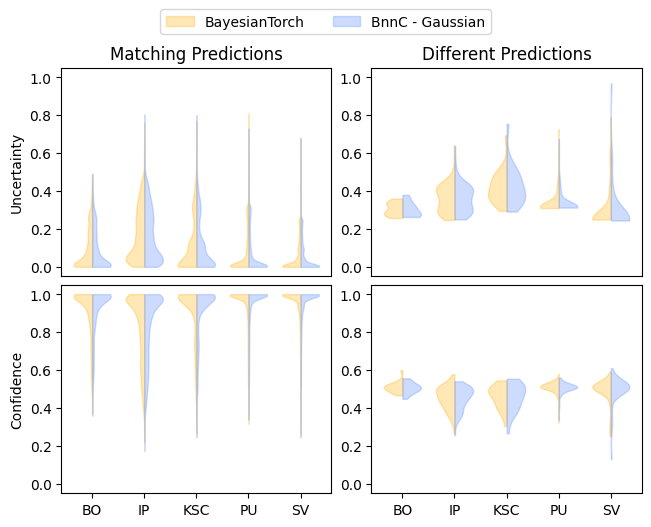

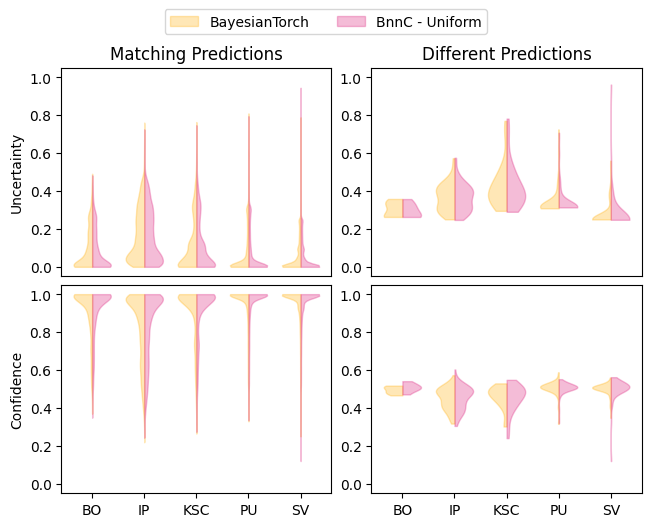

In [18]:
def probplot(d, names, tag, second_color, letter):

    fig = pl.figure(constrained_layout=True)
    axes = fig.subplots(2,2)

    t = 0.7

    for i, l in enumerate(names):
        cdata, pydata, diff_mask, _ = d[f"{l}{letter}"]
        bnnc.plot.same_violin_plot(pydata, cdata, diff_mask, [axes[0][0], axes[1][0]], 1 + i*t, second_color)
        bnnc.plot.diff_violin_plot(pydata, cdata, diff_mask, [axes[0][1], axes[1][1]], 1 + i*t, second_color)

    axes[0][0].set_title("Matching Predictions")
    axes[0][1].set_title("Different Predictions")

    axes[0][0].set_xticks([])
    axes[0][1].set_xticks([])
    axes[0][1].set_ylabel("")
    axes[1][0].set_xticks([1 + i*t for i, _ in enumerate(names)], names)
    axes[1][1].set_xticks([1 + i*t for i, _ in enumerate(names)], names)
    axes[1][1].set_ylabel("")

    fig.legend(
        ["BayesianTorch", f"BnnC - {tag}"],
        bbox_to_anchor=(0.5, 1),
        loc='lower center', ncols=2,
    )

    return fig

probplot(d, testconf.Conf.hyper_model_list, "Gaussian", bnnc.plot.COLOR_1, "G").savefig("hyper_dist_gauss.pdf", bbox_inches='tight')
pl.show()

probplot(d, testconf.Conf.hyper_model_list, "Uniform", bnnc.plot.COLOR_3, "U").savefig("hyper_dist_unif.pdf", bbox_inches='tight')
pl.show()

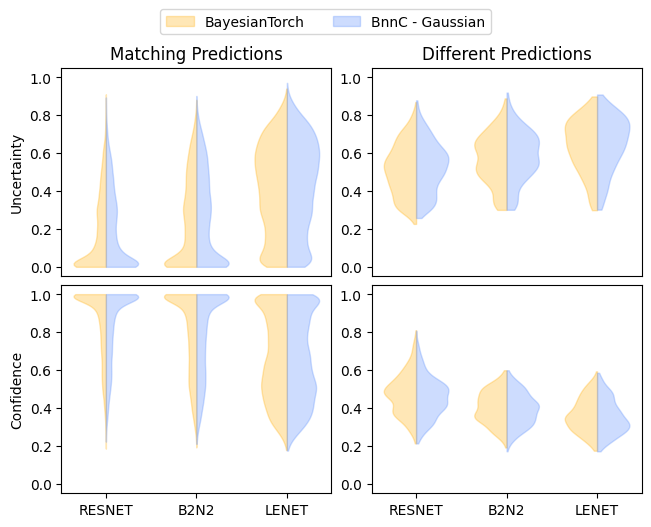

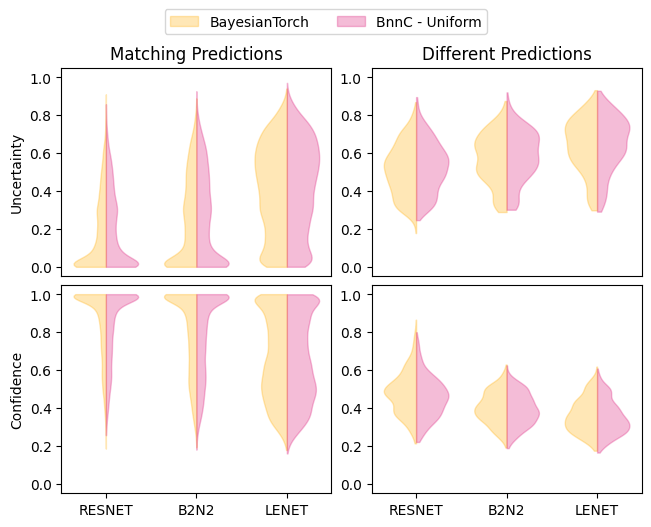

In [19]:
reload(bnnc.plot)

def probplots(d, names, tag, second_color):
    fig = pl.figure(constrained_layout=True)
    axes = fig.subplots(2,2)

    t = 0.7

    for i, l in enumerate(names):
        cdata, pydata, diff_mask, _ = d[l]
        bnnc.plot.same_violin_plot(pydata, cdata, diff_mask, [axes[0][0], axes[1][0]], 1 + i*t, second_color)
        bnnc.plot.diff_violin_plot(pydata, cdata, diff_mask, [axes[0][1], axes[1][1]], 1 + i*t, second_color)

    axes[0][0].set_title("Matching Predictions")
    axes[0][1].set_title("Different Predictions")

    axes[0][0].set_xticks([])
    axes[0][1].set_xticks([])
    axes[0][1].set_ylabel("")
    axes[1][0].set_xticks([1, 1 + 1*t, 1 + 2*t], ["RESNET", "B2N2", "LENET"])
    axes[1][1].set_xticks([1, 1 + 1*t, 1 + 2*t], ["RESNET", "B2N2", "LENET"])
    axes[1][1].set_ylabel("")

    fig.legend(
        ["BayesianTorch", f"BnnC - {tag}"],
        bbox_to_anchor=(0.5, 1),
        loc='lower center', ncols=2,
    )

    fsize = fig.get_size_inches()
    fig.set_size_inches(fsize * np.array([1,1]))

    return fig

probplots(d, ["RG", "BG", "LG"], "Gaussian", bnnc.plot.COLOR_1).savefig("dist_gauss.pdf", bbox_inches='tight')
pl.show()

probplots(d, ["RU", "BU", "LU"], "Uniform", bnnc.plot.COLOR_3).savefig("dist_unif.pdf", bbox_inches='tight')
pl.show()


In [4]:
reload(bnnc.uncertainty)

def load_model_predictions(modelname:str, fixed_bits:int, table):
    preds = np.load(testconf.prediction_path(modelname, "gaussian", fixed_bits))["arr_0"]
    preds = preds.transpose((1,0,2))
    _, test_data = testconf.get_data(modelname)
    targets = np.array(test_data.targets)[:len(preds)]
    gauss = bnnc.uncertainty.analyze_predictions(preds, targets)

    preds = np.load(testconf.prediction_path(modelname, "uniform", fixed_bits))["arr_0"]
    preds = preds.transpose((1,0,2))
    unif = bnnc.uncertainty.analyze_predictions(preds, targets)

    preds = np.load(testconf.baseline_path(modelname))["arr_0"]
    preds = preds.transpose((1,0,2))
    pydata = bnnc.uncertainty.analyze_predictions(preds, targets)

    mr_gauss, df_gauss = bnnc.uncertainty.match_ratio(gauss["analyzed_predictions"], pydata["analyzed_predictions"])
    mr_unif, df_unif = bnnc.uncertainty.match_ratio(unif["analyzed_predictions"], pydata["analyzed_predictions"])

    table.add_rows([
        [modelname, f"{100 * pydata["acc"]:.3f}", f"{100 * pydata["ece"]:.3f}", f"{100 * pydata["uce"]:.3f}", f"{100 * pydata["re"]:.3f}", f"-"],
        [f"{modelname}-gaussian", f"{100 * gauss["acc"]:.3f}", f"{100 * gauss["ece"]:.3f}", f"{100 * gauss["uce"]:.3f}", f"{100 * gauss["re"]:.3f}", f"{mr_gauss:.3f}"],
        [f"{modelname}-uniform", f"{100 * unif["acc"]:.3f}", f"{100 * unif["ece"]:.3f}", f"{100 * unif["uce"]:.3f}", f"{100 * unif["re"]:.3f}", f"{mr_unif:.3f}"]
    ])

    return {
        "python": pydata,
        "gauss": gauss,
        "unif": unif,
    }

table = PrettyTable()
table.set_style(MSWORD_FRIENDLY)
table.field_names = [f"Name", "Accuracy %", "ECE %", "UCE %", "RE %", "Match"]

data = {}

for name in testconf.Conf.model_list:
    data[name] = load_model_predictions(name, 10, table)

print(table)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
|       Name      | Accuracy % | ECE % | UCE % |  RE % | Match |
|        BO       |   90.517   | 0.881 | 2.126 | 2.725 |   -   |
|   BO-gaussian   |   90.456   | 1.559 | 2.473 | 4.113 | 0.990 |
|    BO-uniform   |   90.517   | 1.091 | 2.344 | 3.186 | 0.996 |
|        IP       |   81.444   | 0.944 | 4.341 | 2.402 |   -   |
|   IP-gaussian   |   81.561   | 0.808 | 3.929 | 2.291 | 0.985 |
|    IP-uniform   |   81.620   | 1.078 | 4.011 | 2.508 | 0.988 |
|       KSC       |   92.632   | 3.599 | 5.793 | 6.492 |   -   |
|   KSC-gaussian  |   92.479   | 3.428 | 5.469 | 5.882 | 0.993 |
|   KSC-uniform   |   92.517   | 3.614 | 5.563 | 6.166 | 0.992 |
|        PU       |   90.111   | 2.680 | 2.127 | 5.752 |   -   |
|   PU-gaussian   |   90.135   | 2.623 | 2.030 | 5.672 | 0.996 |
|    PU-uniform   |   90.139   | 2.631 | 2.028 | 5.646 | 0.996 |
|        SV       |   92.581   | 0.747 | 

In [5]:
table = PrettyTable()
table.set_style(MSWORD_FRIENDLY)
table.field_names = [f"Name", "P acc cert MAE", "P unc inn MAE"]


for name in testconf.Conf.model_list:
    pydata = data[name]["python"]
    gauss = data[name]["gauss"]
    unif = data[name]["unif"]

    qpy = bnnc.uncertainty.uncertainty_quality(pydata["analyzed_predictions"])
    qgauss = bnnc.uncertainty.uncertainty_quality(gauss["analyzed_predictions"])
    qunif = bnnc.uncertainty.uncertainty_quality(unif["analyzed_predictions"])

    mae_1 = np.abs(qpy["p_acc_cert"].to_numpy() - qgauss["p_acc_cert"].to_numpy()).mean()
    mae_2 = np.abs(qpy["p_unc_inn"].to_numpy() - qgauss["p_unc_inn"].to_numpy()).mean()
    

    table.add_rows([
        [f"{name}-gaussian", f"{mae_1:.5f}", f"{mae_2:.5f}"],
    ])

    mae_1 = np.abs(qpy["p_acc_cert"].to_numpy() - qunif["p_acc_cert"].to_numpy()).mean()
    mae_2 = np.abs(qpy["p_unc_inn"].to_numpy() - qunif["p_unc_inn"].to_numpy()).mean()

    table.add_rows([
        [f"{name}-uniform", f"{mae_1:.5f}", f"{mae_2:.5f}"],
    ])


print(table)


|       Name      | P acc cert MAE | P unc inn MAE |
|   BO-gaussian   |    0.00098     |    0.00446    |
|    BO-uniform   |    0.00057     |    0.00494    |
|   IP-gaussian   |    0.00117     |    0.00251    |
|    IP-uniform   |    0.00156     |    0.00369    |
|   KSC-gaussian  |    0.00121     |    0.00632    |
|   KSC-uniform   |    0.00106     |    0.00605    |
|   PU-gaussian   |    0.00023     |    0.00203    |
|    PU-uniform   |    0.00027     |    0.00220    |
|   SV-gaussian   |    0.00078     |    0.00169    |
|    SV-uniform   |    0.00043     |    0.00138    |
|  LENET-gaussian |    0.00609     |    0.01965    |
|  LENET-uniform  |    0.00487     |    0.01618    |
|  B2N2-gaussian  |    0.00775     |    0.02341    |
|   B2N2-uniform  |    0.00597     |    0.02048    |
| RESNET-gaussian |    0.00680     |    0.01810    |
|  RESNET-uniform |    0.00737     |    0.01701    |


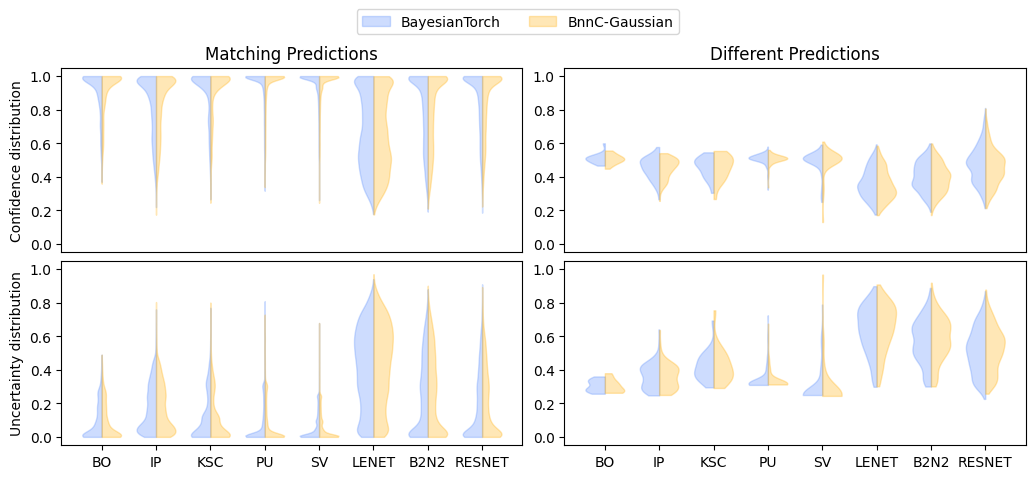

In [46]:
fig, axes = pl.subplots(2,2, layout="constrained")
t = 0.7

pos = []
ax = axes[0][0]
for i, name in enumerate(testconf.Conf.model_list):
    pydata = data[name]["python"]["analyzed_predictions"]
    gauss = data[name]["gauss"]["analyzed_predictions"]
    _, df_gauss = bnnc.uncertainty.match_ratio(gauss, pydata)
    pydata_gauss = pydata["confidence"].to_numpy()[~df_gauss]
    gauss = gauss["confidence"].to_numpy()[~df_gauss]

    p = ax.violinplot(pydata_gauss, positions=[i * 0.7], side="low", showextrema=False)
    for pc in p["bodies"]:
        pc.set_color(bnnc.plot.COLOR_1)

    p = ax.violinplot(gauss, positions=[i * 0.7], side="high", showextrema=False)
    for pc in p["bodies"]:
        pc.set_color(bnnc.plot.COLOR_2)

    pos.append(i * 0.7)
ax.set_ylim(-0.05,1.05)
ax.set_ylabel("Confidence distribution")
ax.set_title("Matching Predictions")
ax.set_xticks([])


pos = []
ax = axes[1][0]
for i, name in enumerate(testconf.Conf.model_list):
    pydata = data[name]["python"]["analyzed_predictions"]
    gauss = data[name]["gauss"]["analyzed_predictions"]
    _, df_gauss = bnnc.uncertainty.match_ratio(gauss, pydata)
    pydata_gauss = pydata["uncertainty"].to_numpy()[~df_gauss]
    gauss = gauss["uncertainty"].to_numpy()[~df_gauss]

    p = ax.violinplot(pydata_gauss, positions=[i * 0.7], side="low", showextrema=False)
    for pc in p["bodies"]:
        pc.set_color(bnnc.plot.COLOR_1)

    p = ax.violinplot(gauss, positions=[i * 0.7], side="high", showextrema=False)
    for pc in p["bodies"]:
        pc.set_color(bnnc.plot.COLOR_2)

    pos.append(i * 0.7)
ax.set_ylim(-0.05,1.05)
ax.set_ylabel("Uncertainty distribution")
ax.set_xticks(pos, testconf.Conf.model_list)


pos = []
ax = axes[0][1]
for i, name in enumerate(testconf.Conf.model_list):
    pydata = data[name]["python"]["analyzed_predictions"]
    gauss = data[name]["gauss"]["analyzed_predictions"]
    _, df_gauss = bnnc.uncertainty.match_ratio(gauss, pydata)
    pydata_gauss = pydata["confidence"].to_numpy()[df_gauss]
    gauss = gauss["confidence"].to_numpy()[df_gauss]

    p = ax.violinplot(pydata_gauss, positions=[i * 0.7], side="low", showextrema=False)
    for pc in p["bodies"]:
        pc.set_color(bnnc.plot.COLOR_1)

    p = ax.violinplot(gauss, positions=[i * 0.7], side="high", showextrema=False)
    for pc in p["bodies"]:
        pc.set_color(bnnc.plot.COLOR_2)

    pos.append(i * 0.7)
ax.set_ylim(-0.05,1.05)
ax.set_title("Different Predictions")
ax.set_xticks([])


pos = []
ax = axes[1][1]
for i, name in enumerate(testconf.Conf.model_list):
    pydata = data[name]["python"]["analyzed_predictions"]
    gauss = data[name]["gauss"]["analyzed_predictions"]
    _, df_gauss = bnnc.uncertainty.match_ratio(gauss, pydata)
    pydata_gauss = pydata["uncertainty"].to_numpy()[df_gauss]
    gauss = gauss["uncertainty"].to_numpy()[df_gauss]

    p = ax.violinplot(pydata_gauss, positions=[i * 0.7], side="low", showextrema=False)
    for pc in p["bodies"]:
        pc.set_color(bnnc.plot.COLOR_1)

    p = ax.violinplot(gauss, positions=[i * 0.7], side="high", showextrema=False)
    for pc in p["bodies"]:
        pc.set_color(bnnc.plot.COLOR_2)

    pos.append(i * 0.7)
ax.set_ylim(-0.05,1.05)
ax.set_xticks(pos, testconf.Conf.model_list)

fig.legend(
    [
        mpatches.Patch(color=bnnc.plot.COLOR_1, alpha=0.3),
        mpatches.Patch(color=bnnc.plot.COLOR_2, alpha=0.3)
    ], 
    [
        "BayesianTorch", "BnnC-Gaussian"
    ],
    bbox_to_anchor=(0.5, 1),
    loc='lower center', ncols=2,
)

fig.set_size_inches(fig.get_size_inches() * np.array([1.6,0.9]))
fig.savefig("Figures/dist_gauss.pdf", bbox_inches="tight")

pl.show()

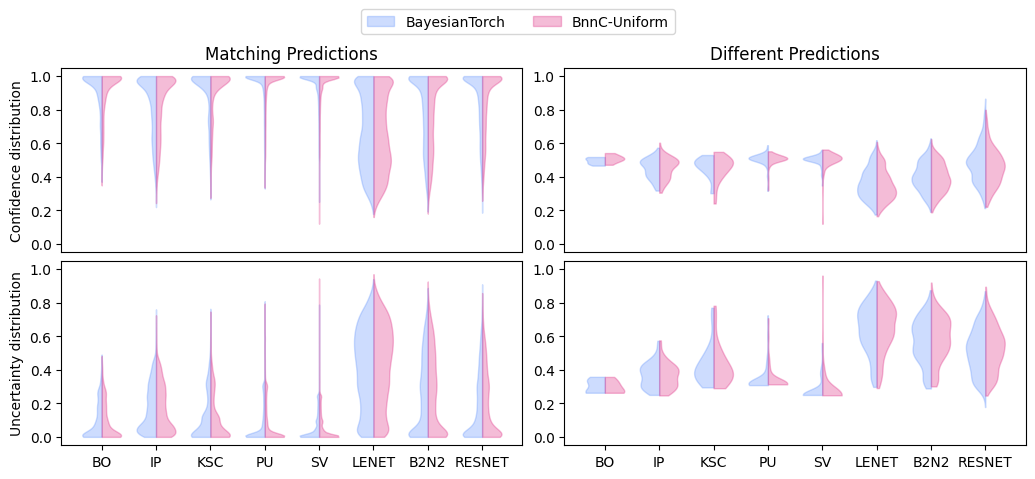

In [49]:
fig, axes = pl.subplots(2,2, layout="constrained")
t = 0.7

pos = []
ax = axes[0][0]
for i, name in enumerate(testconf.Conf.model_list):
    pydata = data[name]["python"]["analyzed_predictions"]
    gauss = data[name]["unif"]["analyzed_predictions"]
    _, df_gauss = bnnc.uncertainty.match_ratio(gauss, pydata)
    pydata_gauss = pydata["confidence"].to_numpy()[~df_gauss]
    gauss = gauss["confidence"].to_numpy()[~df_gauss]

    p = ax.violinplot(pydata_gauss, positions=[i * 0.7], side="low", showextrema=False)
    for pc in p["bodies"]:
        pc.set_color(bnnc.plot.COLOR_1)

    p = ax.violinplot(gauss, positions=[i * 0.7], side="high", showextrema=False)
    for pc in p["bodies"]:
        pc.set_color(bnnc.plot.COLOR_3)

    pos.append(i * 0.7)
ax.set_ylim(-0.05,1.05)
ax.set_ylabel("Confidence distribution")
ax.set_title("Matching Predictions")
ax.set_xticks([])


pos = []
ax = axes[1][0]
for i, name in enumerate(testconf.Conf.model_list):
    pydata = data[name]["python"]["analyzed_predictions"]
    gauss = data[name]["unif"]["analyzed_predictions"]
    _, df_gauss = bnnc.uncertainty.match_ratio(gauss, pydata)
    pydata_gauss = pydata["uncertainty"].to_numpy()[~df_gauss]
    gauss = gauss["uncertainty"].to_numpy()[~df_gauss]

    p = ax.violinplot(pydata_gauss, positions=[i * 0.7], side="low", showextrema=False)
    for pc in p["bodies"]:
        pc.set_color(bnnc.plot.COLOR_1)

    p = ax.violinplot(gauss, positions=[i * 0.7], side="high", showextrema=False)
    for pc in p["bodies"]:
        pc.set_color(bnnc.plot.COLOR_3)

    pos.append(i * 0.7)
ax.set_ylim(-0.05,1.05)
ax.set_ylabel("Uncertainty distribution")
ax.set_xticks(pos, testconf.Conf.model_list)


pos = []
ax = axes[0][1]
for i, name in enumerate(testconf.Conf.model_list):
    pydata = data[name]["python"]["analyzed_predictions"]
    gauss = data[name]["unif"]["analyzed_predictions"]
    _, df_gauss = bnnc.uncertainty.match_ratio(gauss, pydata)
    pydata_gauss = pydata["confidence"].to_numpy()[df_gauss]
    gauss = gauss["confidence"].to_numpy()[df_gauss]

    p = ax.violinplot(pydata_gauss, positions=[i * 0.7], side="low", showextrema=False)
    for pc in p["bodies"]:
        pc.set_color(bnnc.plot.COLOR_1)

    p = ax.violinplot(gauss, positions=[i * 0.7], side="high", showextrema=False)
    for pc in p["bodies"]:
        pc.set_color(bnnc.plot.COLOR_3)

    pos.append(i * 0.7)
ax.set_ylim(-0.05,1.05)
ax.set_title("Different Predictions")
ax.set_xticks([])


pos = []
ax = axes[1][1]
for i, name in enumerate(testconf.Conf.model_list):
    pydata = data[name]["python"]["analyzed_predictions"]
    gauss = data[name]["unif"]["analyzed_predictions"]
    _, df_gauss = bnnc.uncertainty.match_ratio(gauss, pydata)
    pydata_gauss = pydata["uncertainty"].to_numpy()[df_gauss]
    gauss = gauss["uncertainty"].to_numpy()[df_gauss]

    p = ax.violinplot(pydata_gauss, positions=[i * 0.7], side="low", showextrema=False)
    for pc in p["bodies"]:
        pc.set_color(bnnc.plot.COLOR_1)

    p = ax.violinplot(gauss, positions=[i * 0.7], side="high", showextrema=False)
    for pc in p["bodies"]:
        pc.set_color(bnnc.plot.COLOR_3)

    pos.append(i * 0.7)
ax.set_ylim(-0.05,1.05)
ax.set_xticks(pos, testconf.Conf.model_list)

fig.legend(
    [
        mpatches.Patch(color=bnnc.plot.COLOR_1, alpha=0.3),
        mpatches.Patch(color=bnnc.plot.COLOR_3, alpha=0.3)
    ], 
    [
        "BayesianTorch", "BnnC-Uniform"
    ],
    bbox_to_anchor=(0.5, 1),
    loc='lower center', ncols=2,
)

fig.set_size_inches(fig.get_size_inches() * np.array([1.6,0.9]))
fig.savefig("Figures/dist_unif.pdf", bbox_inches="tight")

pl.show()